In [1]:
# Import libraries
import pandas as pd
import numpy as np
import math

In [2]:
import matplotlib.pyplot as plt
from scipy import sparse
from cplex import Cplex, CplexError
import cplex
from docplex.mp.model import Model
import cvxpy as cp
# import cyipopt as ipopt

In [3]:
# From Assignment 1:

# Complete the following functions
def strat_buy_and_hold(x_init, cash_init, mu, Q, cur_prices, counter, rfr):
    x_optimal = x_init
    cash_optimal = cash_init
    weights = x_optimal * cur_prices / (np.sum(x_init * cur_prices))
    
    return x_optimal, cash_optimal, weights

def strat_equally_weighted(x_init, cash_init, mu, Q, cur_prices, counter, rfr):
    fee_rate = 0.005  # Transaction fee rate
    # Compute total portfolio value (current holdings + free cash)
    current_value = np.sum(x_init * cur_prices) + cash_init
    
    # Initially, set the target weights equally
    w = 1 / N
    
    # Initialize variables for iteration
    iteration = 0
    max_iterations = 100  # Prevent infinite loop
    cash_optimal = cash_init
    x_optimal = np.copy(x_init)
    # reweight_counter = 0 # Optional counter to see how many times reweighting occurs due to transaction costs.
    
    while iteration < max_iterations:
        iteration += 1
        # Compute target cash allocation for each asset
        cash_distribution = current_value * w
        # Calculate the target number of shares, rounding down
        x_target = np.floor(cash_distribution / cur_prices).astype(int)
        # Calculate the total cost considering buying/selling shares & transaction fees
        transaction_costs = np.sum(np.abs(x_target - x_optimal) * cur_prices) * fee_rate
        # Calculate cash required for rebalancing to target allocation including transaction costs
        cash_required = np.sum((x_target - x_optimal) * cur_prices) + transaction_costs
        
        if cash_required <= cash_optimal:
            # If enough cash is available, finalize the optimal allocation
            x_optimal = x_target
            cash_optimal -= cash_required  # Update remaining free cash after transactions
            break
        else:
            # reweight_counter += 1
            # Not enough cash, adjust target weights proportionally and retry
            adjustment_factor = cash_optimal / (cash_required + 1e-6)  # Add small value to avoid division by zero
            w *= adjustment_factor  # Adjust weights down to fit the budget
    
    if iteration == max_iterations:
        print("Max iterations reached, solution may not be optimal.")
    
    # Recompute the final cash optimal to account for rounding of shares
    cash_optimal = current_value - np.sum(x_optimal * cur_prices) - np.sum(np.abs(x_optimal - x_init) * cur_prices * fee_rate)
    
    w = x_optimal * cur_prices / (current_value - cash_optimal)
    
    return x_optimal, cash_optimal, w

def strat_min_variance(x_init, cash_init, mu, Q, cur_prices, counter, rfr):
    # Compute total portfolio value (current holdings + free cash)
    current_value = np.sum(x_init * cur_prices) + cash_init
    
    # Create an instance of a model
    mdl = Model('MinVariancePortfolio')
    
    # Decision variables for asset weights
    y = mdl.continuous_var_list(N, name='y')
    
    # Objective function: Minimize the portfolio variance
    Q_matrix = [[Q[i, j] for j in range(N)] for i in range(N)]
    mdl.minimize(mdl.sum(Q_matrix[i][j] * y[i] * y[j] for i in range(N) for j in range(N)))
    
    # Constraints
    # Sum of y (weights) equals 1 (100% of the portfolio)
    mdl.add_constraint(mdl.sum(y[i] for i in range(N)) == 1)
    # Non-negativity constraints on weights
    mdl.add_constraints(y[i] >= 0 for i in range(N))
    
    # Solve the problem
    solution = mdl.solve(log_output=False)
    if solution:
        y_values = np.array([y[i].solution_value for i in range(N)])
        x_optimal = np.floor(y_values * current_value / cur_prices).astype(int)
    else:
        raise Exception("Problem is infeasible or unbounded.")

    # Calculate leftover free cash
    available_cash = current_value - np.sum(x_optimal * cur_prices)

    # Check and adjust for transaction fees using 'adjust_portfolio_for_fees'
    fee_rate = 0.005  # Transaction fee rate
    x_optimal, weights = adjust_portfolio_for_fees(x_init, x_optimal, cur_prices, fee_rate, available_cash, current_value)
    # Re-adjust leftover cash
    cash_optimal = current_value - np.sum(x_optimal * cur_prices) - np.sum(np.abs(x_optimal - x_init) * cur_prices * fee_rate)
    
    return x_optimal, cash_optimal, weights

def strat_max_Sharpe(x_init, cash_init, mu, Q, cur_prices, counter, rfr = 0.025):

    # Risk free rate to daily calculation
    rfr = rfr/252
    current_value = np.sum(x_init * cur_prices) + cash_init # Current Portfolio Value + Free Cash
    
    # Create an instance of a model
    mdl = Model('MaxSharpeRatio')
    
    # Decision variables
    y = mdl.continuous_var_list(N, name='y')
    kappa = mdl.continuous_var(name='kappa', lb=0)
    
    lambda_shrinkage = 0.1
    n = Q.shape[0]
    avg_variance = np.trace(Q) / n
    target_matrix = np.eye(n) * avg_variance
    shrunk_cov_matrix = lambda_shrinkage * target_matrix + (1 - lambda_shrinkage) * Q
    W = shrunk_cov_matrix
    
    # Objective function
    Q_matrix = [[Q[i, j] for j in range(N)] for i in range(N)]
    mdl.minimize(mdl.sum(Q_matrix[i][j] * y[i] * y[j] for i in range(N) for j in range(N)))
    
    # Constraints
    # slippage = mdl.continuous_var(lb=-0.1, ub=0.1, name='slippage')  # Adjust bounds as necessary
    # mdl.add_constraint(mdl.sum((mu[i] - rfr) * y[i] for i in range(N)) + slippage == 1)
    mdl.add_constraint(mdl.sum((mu[i] - rfr) * y[i] for i in range(N)) == 1)
    mdl.add_constraints(y[i] >= 0 for i in range(N))
    mdl.add_constraint(mdl.sum(y[i] for i in range(N)) == kappa)
    
    # Solve the problem
    solution = mdl.solve(log_output=False)
    
    if solution:
        y_values = np.array([y[i].solution_value for i in range(N)])
        kappa_value = kappa.solution_value
        w_star = y_values / kappa_value # Get weights
        x_optimal = np.floor(w_star * current_value / cur_prices).astype(int) # Get optimal share distribution
    else:
        print("Problem is infeasible or unbounded, no adjustment this period.")
        x_optimal = x_init
        cash_optimal = cash_init
        weights = x_optimal * cur_prices / (np.sum(x_init * cur_prices))
    
        return x_optimal, cash_optimal, weights
        # raise Exception("Problem is infeasible or unbounded.")
        
    available_cash = current_value - np.sum(x_optimal * cur_prices) # Calculate leftover Cash

    # Adjust for transaction fees (Same as min variance strat)
    fee_rate = 0.005  # Transaction fee rate
    x_optimal, weights = adjust_portfolio_for_fees(x_init, x_optimal, cur_prices, fee_rate, available_cash, current_value)
    # Re-adjust leftover cash for transaction costs
    cash_optimal = current_value - np.sum(x_optimal * cur_prices) - np.sum(np.abs(x_optimal - x_init) * cur_prices * fee_rate)
    
    return x_optimal, cash_optimal, weights

def adjust_portfolio_for_fees(x_init, x_optimal, cur_prices, fee_rate, available_cash, current_value):
    '''
    Function for adjusting the optimal portfolio selection by taking into account the transaction fee.
    Heuristic approach will check if the current approach is feasible (enough leftover cash for transaction costs), and
    if not feasible, it will reduce the weights by a common ratio (99%) before updating the purchasing numbers and recalculating 
    transaction fees and available cash. This loop continues until the available cash is greater than the transaction fees.
    '''
    # Calculate initial transaction fees
    transaction_volumes = np.abs(x_optimal - x_init) * cur_prices
    initial_fees = np.sum(transaction_volumes) * fee_rate
    
    # Check if rebalancing is feasible within available cash
    if initial_fees <= available_cash:
        weights = x_init * cur_prices / (current_value - available_cash)
        return x_optimal, weights  # No adjustment needed
        
    portfolio_value = current_value - available_cash # allocated cash to portfolio
    # Adjust portfolio weights
    while available_cash < initial_fees:
        
        # Get weights:
        weights = x_optimal * cur_prices / (current_value - available_cash) #Should sum to 1
        w_sum = round(np.sum(weights),5).astype(int)
        assert w_sum == 1, print(f"Sum of weights not equal to 1. Sum = {w_sum}")
            
        # Reduce weights by common factor (No longer adding to 100% of current value)
        weights *= 0.99 #reduce to 99% of current distribution
        # Get new stock distribution
        x_new = np.floor(weights * portfolio_value / cur_prices).astype(int)
        # Calculate new available cash
        new_available_cash = available_cash + np.sum(cur_prices * (x_optimal - x_new))
        # Calculate new transaction costs:
        new_transaction_fees = np.sum(np.abs(x_new - x_init) * cur_prices * fee_rate)

        # Update variables for next loop
        available_cash = new_available_cash
        transaction_fees = new_transaction_fees
        x_optimal = x_new
        
    weights = x_optimal * cur_prices / (current_value - available_cash)
    return x_optimal, weights # Return the last feasible adjustment

In [101]:
# New to Assignment 2:

def strat_equal_risk_contr(x_init, cash_init, mu, Q, cur_prices, counter, rfr):
    
    # Calculate current value
    current_value = np.sum(x_init * cur_prices) + cash_init
    
    # Create an instance of a model
    mdl = Cplex()
    mdl.set_log_stream(None)  # No logging
    mdl.set_results_stream(None)  # Suppress result output
    mdl.set_problem_type(Cplex.problem_type.LP)
    mdl.objective.set_sense(mdl.objective.sense.minimize)
    
    # Decision variables for asset weights
    w_names = ['w_{}'.format(i) for i in range(N)] # Create weight names
    mdl.variables.add(names=w_names, lb=[0]*N)  # Weights are non-negative
    
    # Additional variables for risk contributions (one for each asset)
    rc_names = ['rc_{}'.format(i) for i in range(N)] # Risk names
    mdl.variables.add(names=rc_names, lb=[0]*N)  # Risk contributions are non-negative
    
    # Objective: Minimize the sum of squared deviations of risk contributions from the mean risk contribution
    mdl.objective.set_linear([(rc_names[i], 1.0) for i in range(N)])
    mean_rc = 1/N  # Assuming equal risk contribution, the mean risk contribution is 1/N
    
    # Constraints to ensure each asset's risk contribution is equal
    # We calculate the risk contribution of asset i as w_i * (Q*w)_i
    # Then, we enforce that each asset's risk contribution is equal to its respective variable in rc_names
    for i in range(N):
        Qw_i_expr = [[w_names[j], Q[i][j]] for j in range(N)]
        mdl.linear_constraints.add(
            lin_expr=[cplex.SparsePair(ind=[rc_names[i]] + [w_names[j] for j in range(N)], val=[-1.0] + [Q[i][j] for j in range(N)])],
            senses=["E"],
            rhs=[0]
        )
    
    # Constraint to ensure the sum of weights is equal to 1 (full investment of portfolio)
    mdl.linear_constraints.add(
        lin_expr=[[w_names, [1.0]*N]],
        senses=["E"],
        rhs=[1.0]
    )
    
    try:
        # Solve the problem
        mdl.solve()
    except CplexError as exc:
        print(exc)
        return
    
    # Extract the solution
    w_star = np.array([mdl.solution.get_values('w_{}'.format(i)) for i in range(N)])
    x_optimal = np.floor(w_star * current_value / cur_prices).astype(int)  # Optimal shares to hold

    # Check that the optimization satifies that the sum of risk contributions is equal to portfolio standard deviation
    is_approx_equal, sum_of_contributions, portfolio_std_dev = verify_erc(w_star, Q)
    assert is_approx_equal != True, print("Risk contributions do not add up to portfolio standard deviation.")
    
    available_cash = current_value - np.sum(x_optimal * cur_prices)  # Calculate leftover cash

    # Adjust for transaction fees (Same as min variance strat)
    fee_rate = 0.005  # Transaction fee rate
    x_optimal, weights = adjust_portfolio_for_fees(x_init, x_optimal, cur_prices, fee_rate, available_cash, current_value)
    
    # Re-adjust leftover cash for transaction costs
    cash_optimal = current_value - np.sum(x_optimal * cur_prices) - np.sum(np.abs(x_optimal - x_init) * cur_prices * fee_rate)
    
    return x_optimal, cash_optimal, weights
    
def verify_erc(weights, covariance_matrix):
    # Calculate portfolio standard deviation
    portfolio_variance = np.dot(weights.T, np.dot(covariance_matrix, weights))
    portfolio_std_dev = np.sqrt(portfolio_variance)
    
    # Calculate individual risk contributions
    marginal_contributions = np.dot(covariance_matrix, weights)
    individual_risk_contributions = weights * marginal_contributions
    
    # Sum of individual risk contributions
    sum_of_contributions = np.sum(individual_risk_contributions)
    
    # Check if sum of individual risk contributions is approximately equal to portfolio standard deviation
    is_approx_equal = np.isclose(sum_of_contributions, portfolio_std_dev)
    
    return is_approx_equal, sum_of_contributions, portfolio_std_dev
    
def strat_lever_max_Sharpe(x_init, cash_init, mu, Q, cur_prices, counter, leverage = 2, rfr = 0.025):
    """
    Takes a long 200% position by shorting the risk free asset. My approach will have this function take the short position only once at
    the beginning of the portfolio creation, and pay off the interest as it's incurred.
    """
    # # Calculate bimonthly rfr
    # rfr_bi = (1 + rfr)**(1/6) - 1
    
    # Starts the same as before
    current_value = np.sum(x_init * cur_prices) + cash_init  # Current Portfolio Value + Free Cash
       
    mdl = Model('LeveragedMaxSharpeRatio')
    
    # Decision variables
    y = mdl.continuous_var_list(N, name='y')
    kappa = mdl.continuous_var(name='kappa', lb=0)
    
    # Objective function remains the same
    Q_matrix = [[Q[i, j] for j in range(N)] for i in range(N)]
    mdl.minimize(mdl.sum(Q_matrix[i][j] * y[i] * y[j] for i in range(N) for j in range(N)))
    
    # Adjust constraints for leveraging
    mdl.add_constraint(mdl.sum((mu[i] - rfr/252) * y[i] for i in range(N)) == 1)
    mdl.add_constraints(y[i] >= 0 for i in range(N))
    mdl.add_constraint(mdl.sum(y[i] for i in range(N)) == kappa)
    
    # Solve the problem
    solution = mdl.solve(log_output=False)

    # Check for solution
    if solution:
        pass
    else:
        # If cplex didn't find a solution, were just going to be lazy and pass this rebalancing period, returning the same portfolio.
        print("Problem is infeasible or unbounded, no adjustment this period.")
        x_optimal = x_init
        cash_optimal = cash_init
        weights = x_optimal * cur_prices / (np.sum(x_init * cur_prices))
    
        return x_optimal, cash_optimal, weights
        # raise Exception("Problem is infeasible or unbounded.")

    # Get results
    y_values = np.array([y[i].solution_value for i in range(N)])
    kappa_value = kappa.solution_value
    w_star = (y_values / kappa_value)
    
    # Short Position against RFR
    if counter == 0:
        # Creat short position as a global variable to keep track of.
        global initial_short_investment
        global interest_owed
        initial_short_investment = current_value * (leverage - 1) #Initialize short position.
        interest_owed =  initial_short_investment * (rfr/252) # Flat amount owed each 2 month rebalance
        current_value = current_value * leverage
        
    else:
        # Rebalance the short position:
        current_value = current_value - interest_owed
        
    # calculate leveraged positions
    x_optimal = np.floor(w_star * (current_value) / cur_prices).astype(int)
    
    # Adjust available cash calculation for the leveraged position
    available_cash = (current_value) - np.sum(x_optimal * cur_prices)
    
    fee_rate = 0.005 # Transaction fee rate
    
    # Adjust for transaction fees and borrowing
    x_optimal, weights = adjust_portfolio_for_fees(x_init, x_optimal, cur_prices, fee_rate, available_cash, current_value)
    cash_optimal = (current_value) - np.sum(x_optimal * cur_prices) - np.sum(np.abs(x_optimal - x_init) * cur_prices * fee_rate)
    
    return x_optimal, cash_optimal, weights
    
def strat_robust_optim(x_init, cash_init, mu, Q, cur_prices, counter, rfr):
    
    # Current Portfolio Value (times leverage) + Free Cash
    current_value = np.sum(x_init * cur_prices) + cash_init
    
    # Calculate initial weights
    w0 = x_init * cur_prices / (current_value - cash_init)
    # Required portfolio robustness
    var_matr = np.diag(np.diag(Q))
    # Target portfolio return estimation error is return estimation error of 1/n portfolio
    rob_init = np.dot(w0, np.dot(var_matr, w0)) # return estimation error of initial portfolio
    rob_bnd  = rob_init*2 # target return estimation error

    # Solve for minimum variance portfolio value
    #-------------------------------------------
    w1 = cp.Variable(N)
    prob1 = cp.Problem(cp.Minimize(cp.quad_form(w1, Q)),
                     [sum(w1) == 1,
                      w1 >= 0])
    prob1.solve(solver=cp.CPLEX, verbose=False,cplex_params={"qpmethod": 6})

    # Check for constraint
    assert np.allclose(np.sum(w1.value),1), print("Sum of the weights for minimum variance optimization is not 1.")
    #-------------------------------------------
    
    # Continue following premade code steps
    w_minVar = w1.value
    var_minVar = np.dot(w_minVar, np.dot(Q, w_minVar))
    ret_minVar = np.dot(mu, w_minVar)
    rob_minVar = np.dot(w_minVar, np.dot(var_matr, w_minVar)) # return estimation error of min variance portfolio
    
    # Target portfolio return is return of minimum variance portfolio
    Portf_Retn = ret_minVar
    
    # compute variance matrix
    Qq_rMV = var_matr
    Qq_rMVs = np.sqrt(Qq_rMV)
    w2 = cp.Variable(N)
    
    # Perform optimization
    prob2 = cp.Problem(cp.Minimize(cp.quad_form(w2, Q)),
                     [sum(w2) == 1,
                      mu.T@w2 >= Portf_Retn,
                      cp.quad_form(w2, Qq_rMV) <= rob_bnd,
                      w2 >= 0, w2 <= 1])
    
    prob2.solve(solver=cp.CPLEX, verbose=False)
    w_star = w2.value
    
    # calculate positions
    x_optimal = np.floor(w_star * (current_value) / cur_prices).astype(int)
    # Adjust available cash calculation for the leveraged position
    available_cash = (current_value) - np.sum(x_optimal * cur_prices)
    
    fee_rate = 0.005 # Transaction fee rate
    
    # Adjust for transaction fees and borrowing
    x_optimal, weights = adjust_portfolio_for_fees(x_init, x_optimal, cur_prices, fee_rate, available_cash, current_value)
    cash_optimal = (current_value) - np.sum(x_optimal * cur_prices) - np.sum(np.abs(x_optimal - x_init) * cur_prices * fee_rate)
    
    return x_optimal, cash_optimal, weights

In [115]:
# For maxmimum drawdown over time (MDD)
def find_maxDD(portfolio):
    """
    Input:
        portfolios = list of portfolio values over the current market period (2 months)
    Output:
        MDDs = list of max draw downs for the current trading period
    """
    # Ensure the input is a numpy array for vectorized operations
    # portfolio_values = np.asarray(portfolio)
    
    # Calculate the running maximum
    running_max = np.maximum.accumulate(portfolio.T[0])
    
    # Calculate drawdowns as the difference between the running max and the current value
    drawdowns = (portfolio.T[0] - running_max) / running_max
    
    # Maximum drawdown is the minimum drawdown value
    max_drawdown = drawdowns.min()
    
    return max_drawdown*100

In [130]:
# Input file

# Pick which year to analyze
year = 2022

# Upload
if year == 2020 or year == 2021:
    input_file_prices = '/Users/declanbracken/Development/UofT_Projects/MIE_1622/A2/Daily_closing_prices2020_2021.csv'
elif year == 2008 or year == 2009:
    input_file_prices = '/Users/declanbracken/Development/UofT_Projects/MIE_1622/A2/Daily_closing_prices2008_2009.csv'
elif year == 2022:
    input_file_prices = '/Users/declanbracken/Development/UofT_Projects/MIE_1622/A2/Daily_closing_prices2022.csv'

In [131]:
# Read data into a dataframe
df = pd.read_csv(input_file_prices)

In [132]:
# Convert dates into array [year month day]
def convert_date_to_array(datestr):
    temp = [int(x) for x in datestr.split('/')]
    return [temp[-1], temp[0], temp[1]]

dates_array = np.array(list(df['Date'].apply(convert_date_to_array)))
data_prices = df.iloc[:, 1:].to_numpy()
dates = np.array(df['Date'])

# Find the number of trading days in Nov-Dec 2019 and
# compute expected return and covariance matrix for period 1
day_ind_start0 = 0
if year == 2020 or year == 2021:
    day_ind_end0 = len(np.where(dates_array[:,0]==2019)[0])   # for 2020-2021 csv
elif year == 2008 or year == 2009:
    day_ind_end0 = len(np.where(dates_array[:,0]==2007)[0])   # for 2008-2009 csv
elif year == 2022:
    day_ind_end0 = len(np.where(dates_array[:,0]==2021)[0])   # for 2022 csv

cur_returns0 = data_prices[day_ind_start0+1:day_ind_end0,:] / data_prices[day_ind_start0:day_ind_end0-1,:] - 1
mu = np.mean(cur_returns0, axis = 0)
Q = np.cov(cur_returns0.T)

# Remove datapoints for year 2019
data_prices = data_prices[day_ind_end0:,:]
dates_array = dates_array[day_ind_end0:,:]
dates = dates[day_ind_end0:]

# Initial positions in the portfolio
init_positions = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 902, 0, 0, 0, 0, 0, 0, 0, 0, 0, 17500])

# Initial value of the portfolio
init_value = np.dot(data_prices[0,:], init_positions)
print('\nInitial portfolio value = $ {}\n'.format(round(init_value, 2)))

# Initial portfolio weights
w_init = (data_prices[0,:] * init_positions) / init_value

# Number of periods, assets, trading days
N_periods = 6*len(np.unique(dates_array[:,0])) # 6 periods per year
N = len(df.columns)-1
N_days = len(dates)

if year == 2020 or year == 2021:
    # Annual risk-free rate for years 2020-2021 is 2.5%
    r_rf = 0.025
elif year == 2008 or year == 2009:
    # Annual risk-free rate for years 2008-2009 is 4.5%
    r_rf = 0.045
elif year == 2022:
    # Annual risk-free rate for year 2022 is 3.75%
    r_rf = 0.0375

# Select the risk free rate in use
rrf = r_rf

# Number of strategies
strategy_functions = ['strat_buy_and_hold', 'strat_equally_weighted', 'strat_min_variance', \
                      'strat_max_Sharpe', 'strat_equal_risk_contr', 'strat_lever_max_Sharpe', 'strat_robust_optim']
strategy_names     = ['Buy and Hold', 'Equally Weighted Portfolio', 'Mininum Variance Portfolio', \
                      'Maximum Sharpe Ratio Portfolio', 'Equal Risk Contributions Portfolio', \
                      'Leveraged Max Sharpe Ratio Portfolio', 'Robust Optimization Portfolio']

N_strat = 7 #len(strategy_functions)  # uncomment this in your code
fh_array = [strat_buy_and_hold, strat_equally_weighted, strat_min_variance, strat_max_Sharpe, strat_equal_risk_contr, strat_lever_max_Sharpe, strat_robust_optim]

portf_value = [0] * N_strat
x = np.zeros((N_strat, N_periods),  dtype=np.ndarray)
cash = np.zeros((N_strat, N_periods),  dtype=np.ndarray)
weights = np.zeros((N_strat, N_periods, N)) #store weights
max_drawdowns = np.zeros((N_strat, N_periods)) #to keep track of maximum drawdowns
period_dates = []
counter = 0

for period in range(1, N_periods+1):
   # Compute current year and month, first and last day of the period

    if year == 2020 or year == 2021:
       # Depending on what data/csv (i.e time period) uncomment code
        if dates_array[0, 0] == 20:
            cur_year  = 20 + math.floor(period/7)
            print(cur_year)
        else:
            cur_year  = 2020 + math.floor(period/7)
            
    elif year == 2008 or year == 2009:
        # example for 2008-2009 data
        if dates_array[0, 0] == 8:
           cur_year  = 8 + math.floor(period/7)
        else:
           cur_year  = 2008 + math.floor(period/7)
            
    elif year == 2022:
        if dates_array[0, 0] == 22:
           cur_year  = 20 + math.floor(period/7)
        else:
           cur_year  = 2022 + math.floor(period/7)

    cur_month = 2*((period-1)%6) + 1
    day_ind_start = min([i for i, val in enumerate((dates_array[:,0] == cur_year) & (dates_array[:,1] == cur_month)) if val])
    day_ind_end = max([i for i, val in enumerate((dates_array[:,0] == cur_year) & (dates_array[:,1] == cur_month+1)) if val])
    print('\nPeriod {0}: start date {1}, end date {2}'.format(period, dates[day_ind_start], dates[day_ind_end]))
    # record period dates for plotting max draw downs
    period_dates.append(dates[day_ind_end])
    
    # Prices for the current day
    cur_prices = data_prices[day_ind_start,:]

    # Execute portfolio selection strategies
    for strategy in range(N_strat):

        # Get current portfolio positions
        if period == 1:
            curr_positions = init_positions
            curr_cash = 0
            portf_value[strategy] = np.zeros((N_days, 1))
        else:
            curr_positions = x[strategy, period-2]
            curr_cash = cash[strategy, period-2]

        # Compute strategy
        x[strategy, period-1], cash[strategy, period-1], weights[strategy, period-1,:] = fh_array[strategy](curr_positions, curr_cash, mu, Q, cur_prices, counter, rfr = rrf)

        # Verify that strategy is feasible (you have enough budget to re-balance portfolio)
        # Check that cash account is >= 0
        # Check that we can buy new portfolio subject to transaction costs

        ###################### Insert your code here ############################
        if strategy_names[strategy] == 'Leveraged Max Sharpe Ratio Portfolio':
            if (np.dot(x[strategy, period-1], cur_prices) + cash[strategy, period-1] - initial_short_investment) > (np.dot(curr_positions,cur_prices) + curr_cash):
                raise ValueError("New strategy requires excess funds.")
        else:
            if (np.dot(x[strategy, period-1], cur_prices) + cash[strategy, period-1]) > (np.dot(curr_positions,cur_prices) + curr_cash):
                raise ValueError("New strategy requires excess funds.")
                
        # Check that cash account is >= 0
        if cash[strategy, period-1] < 0:
            raise ValueError("Cash account must be non-negative.")
        # Check that we can buy new portfolio subject to transaction costs
        # I do this check in the last lines of my functions so that it get's added to 'cash[strategy, period-1]' above automatically, 
        # therefore this check is redundant as it would result in a negative cash statement, and then get caught by the above if statement.
        
        # Compute portfolio value
        p_values = np.dot(data_prices[day_ind_start:day_ind_end+1,:], x[strategy, period-1]) + cash[strategy, period-1]
        # Include borrowing cost when calculating portfolio value for max strat sharpe leveraged:
        if strategy_names[strategy] == 'Leveraged Max Sharpe Ratio Portfolio':
            p_values -= initial_short_investment
        portf_value[strategy][day_ind_start:day_ind_end+1] = np.reshape(p_values, (p_values.size,1))
        print('  Strategy "{0}", value begin = $ {1:.2f}, value end = $ {2:.2f}'.format( strategy_names[strategy], 
             portf_value[strategy][day_ind_start][0], portf_value[strategy][day_ind_end][0]))
        # Get max draw down for this period & strategy
        max_drawdowns[strategy, period-1] = find_maxDD(portf_value[strategy][day_ind_start:day_ind_end])
    
    # Increase counter
    counter+=1
      
    # Compute expected returns and covariances for the next period
    cur_returns = data_prices[day_ind_start+1:day_ind_end+1,:] / data_prices[day_ind_start:day_ind_end,:] - 1
    mu = np.mean(cur_returns, axis = 0)
    Q = np.cov(cur_returns.T)




Initial portfolio value = $ 890077.15


Period 1: start date 01/03/2022, end date 02/28/2022
  Strategy "Buy and Hold", value begin = $ 890077.15, value end = $ 924072.93
  Strategy "Equally Weighted Portfolio", value begin = $ 885626.76, value end = $ 885626.76
  Strategy "Mininum Variance Portfolio", value begin = $ 885883.08, value end = $ 863617.62
  Strategy "Maximum Sharpe Ratio Portfolio", value begin = $ 881222.93, value end = $ 800293.52
  Strategy "Equal Risk Contributions Portfolio", value begin = $ 887343.12, value end = $ 883928.19
  Strategy "Leveraged Max Sharpe Ratio Portfolio", value begin = $ 876817.32, value end = $ 714925.19
  Strategy "Robust Optimization Portfolio", value begin = $ 885828.03, value end = $ 862778.64

Period 2: start date 03/01/2022, end date 04/29/2022
  Strategy "Buy and Hold", value begin = $ 921940.14, value end = $ 807230.89
  Strategy "Equally Weighted Portfolio", value begin = $ 881221.67, value end = $ 794180.48
  Strategy "Mininum Varianc

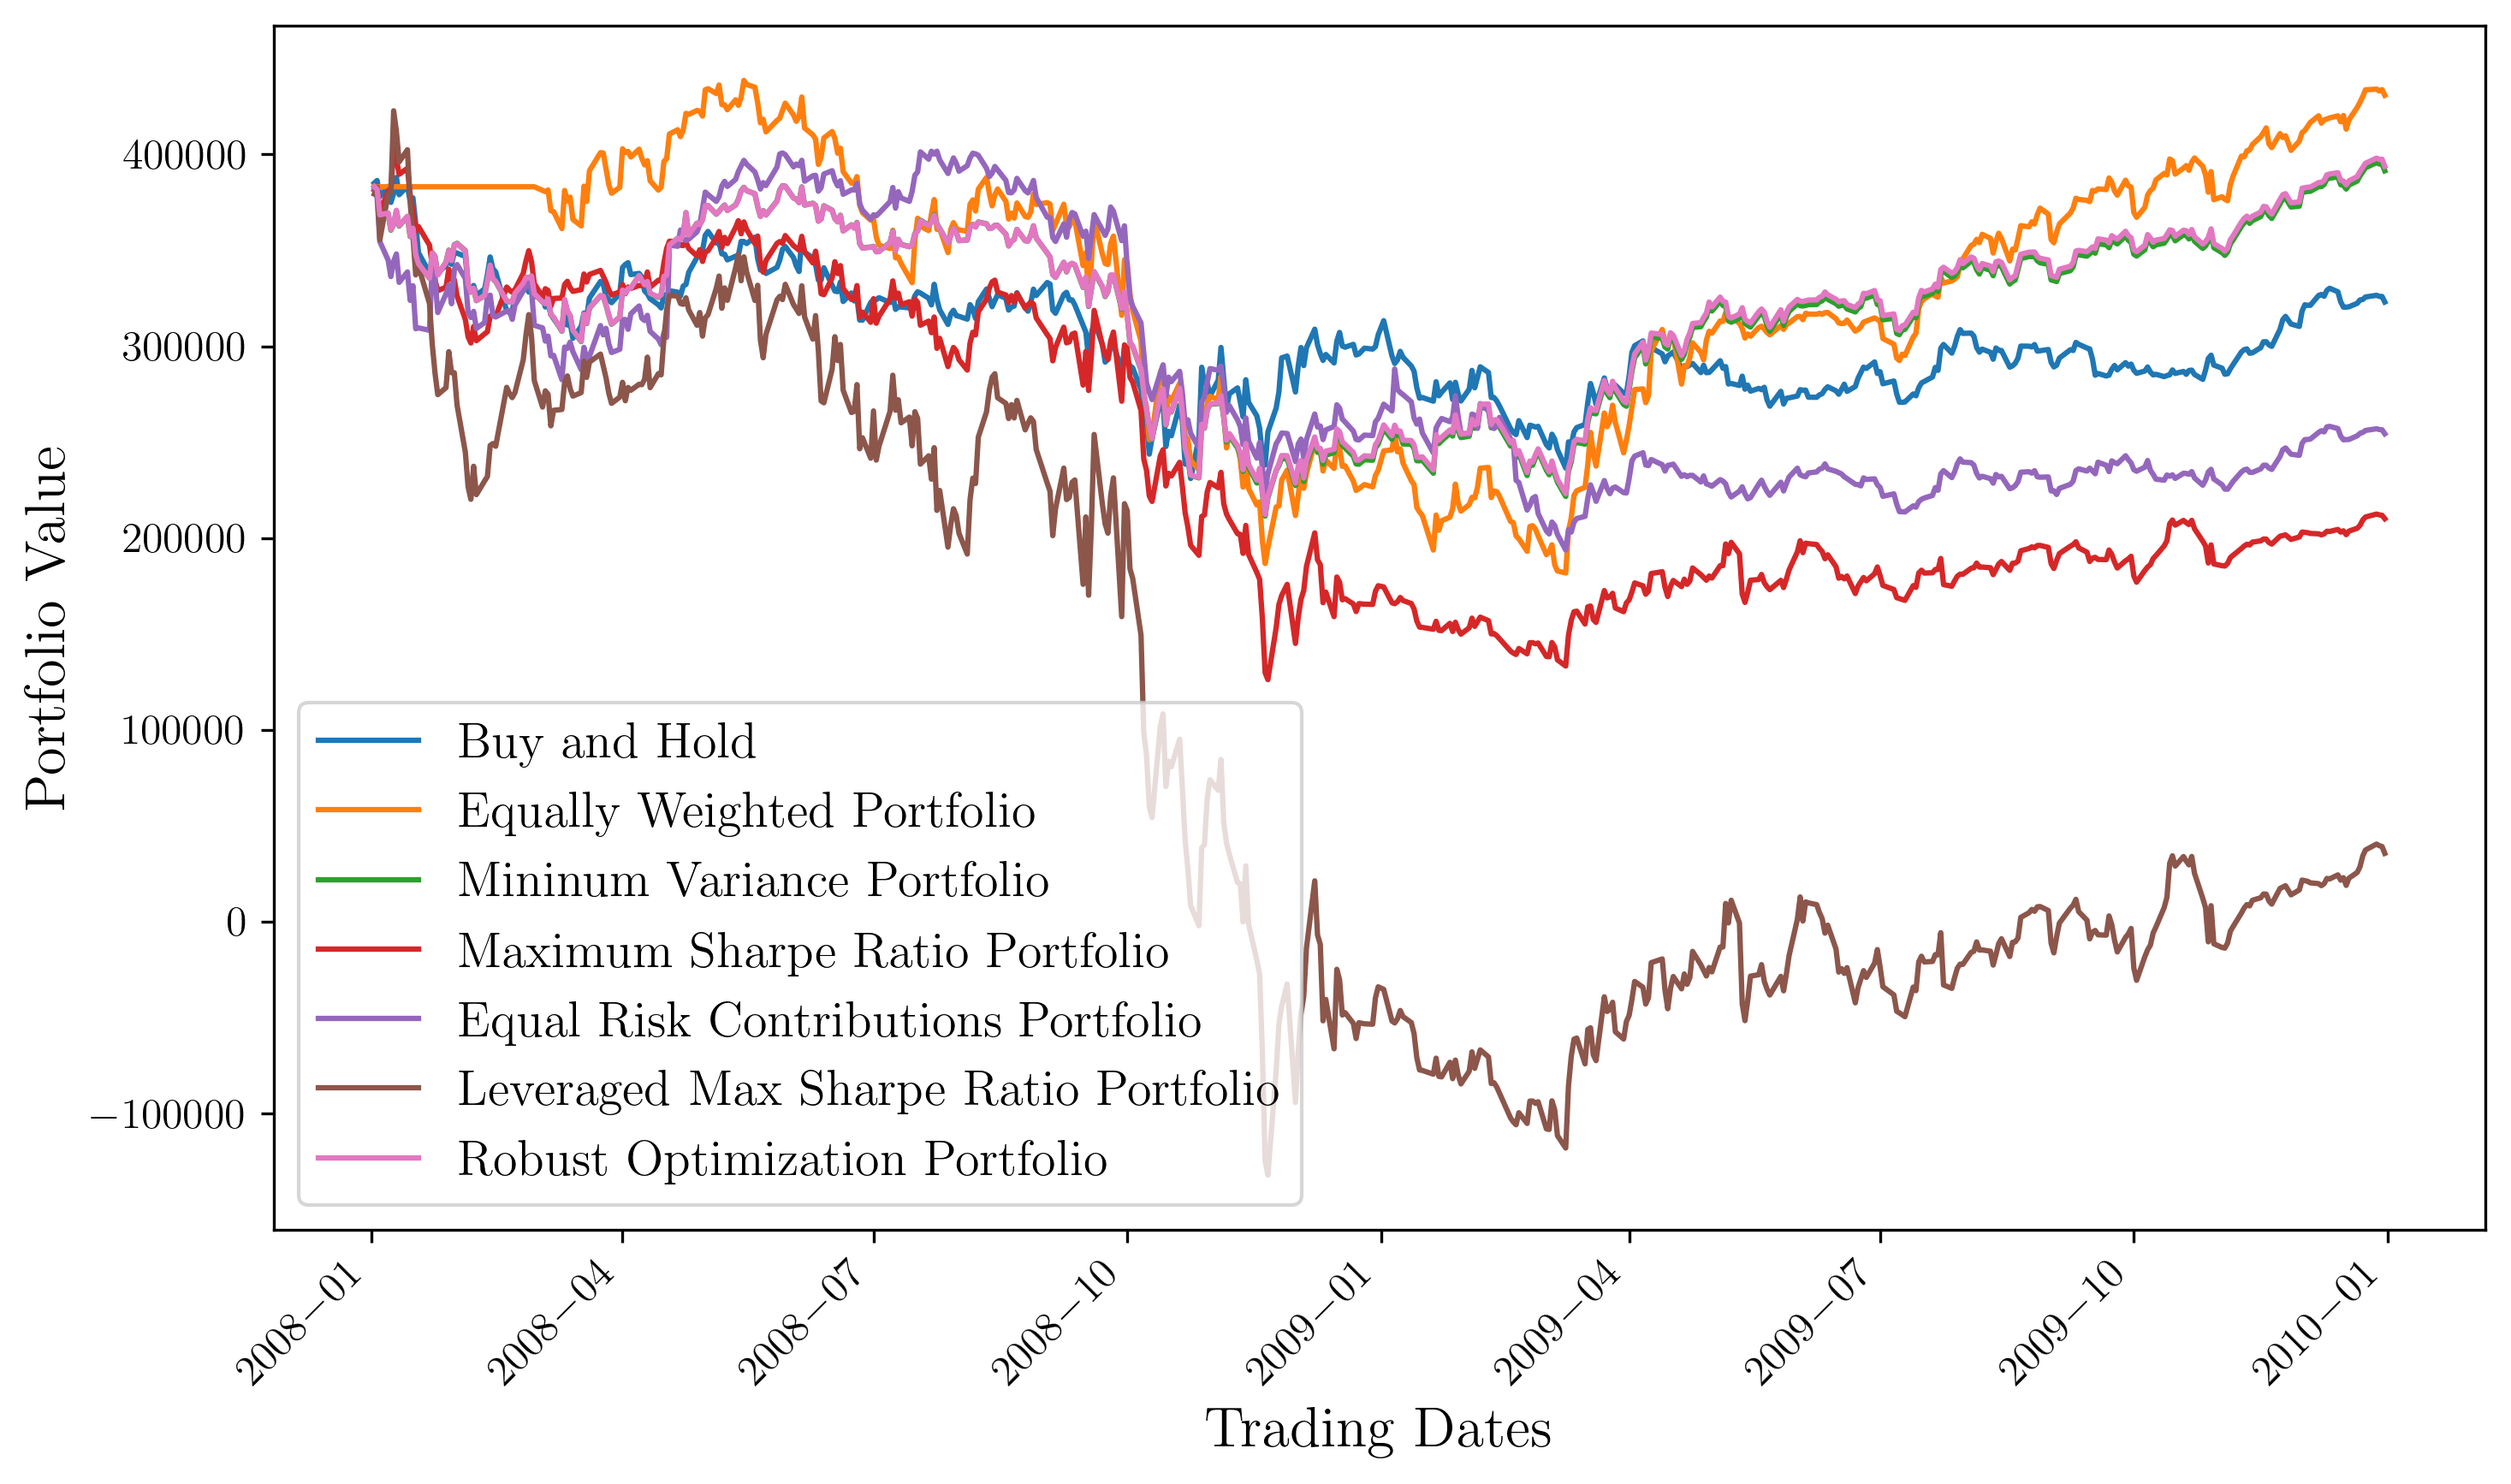

In [124]:
# Plot results
###################### Insert your code here ############################
plt.rcParams.update({
    "font.size": 14,  # Adjusts the base/default font size
    "xtick.labelsize": 12,  # Adjusts x-axis tick label sizes
    "ytick.labelsize": 12,  # Adjusts y-axis tick label sizes
    "text.usetex": True,  
    "font.family": "serif"
})
# For porfolio value over time
dates = pd.to_datetime(dates) 

# Set the figure size and dpi
fig, axs = plt.subplots(figsize=(10, 6), dpi=300)
for i in range(N_strat):
    # Plot
    axs.plot(dates, portf_value[i], label=strategy_names[i])
axs.legend(fontsize=14)
plt.xlabel("Trading Dates", fontsize=16)
plt.ylabel("Portfolio Value", fontsize=16)

# Rotate date labels for better readability
plt.setp(axs.xaxis.get_majorticklabels(), rotation=45, ha="right")
plt.tight_layout()

# Specify the directory and filename where you want to save the figure
directory = '/Users/declanbracken/Development/UofT_Projects/MIE_1622/A2/Graphs/'
filename = 'PortfolioValue_2009.png'
full_path = directory + filename
# plt.savefig(full_path)


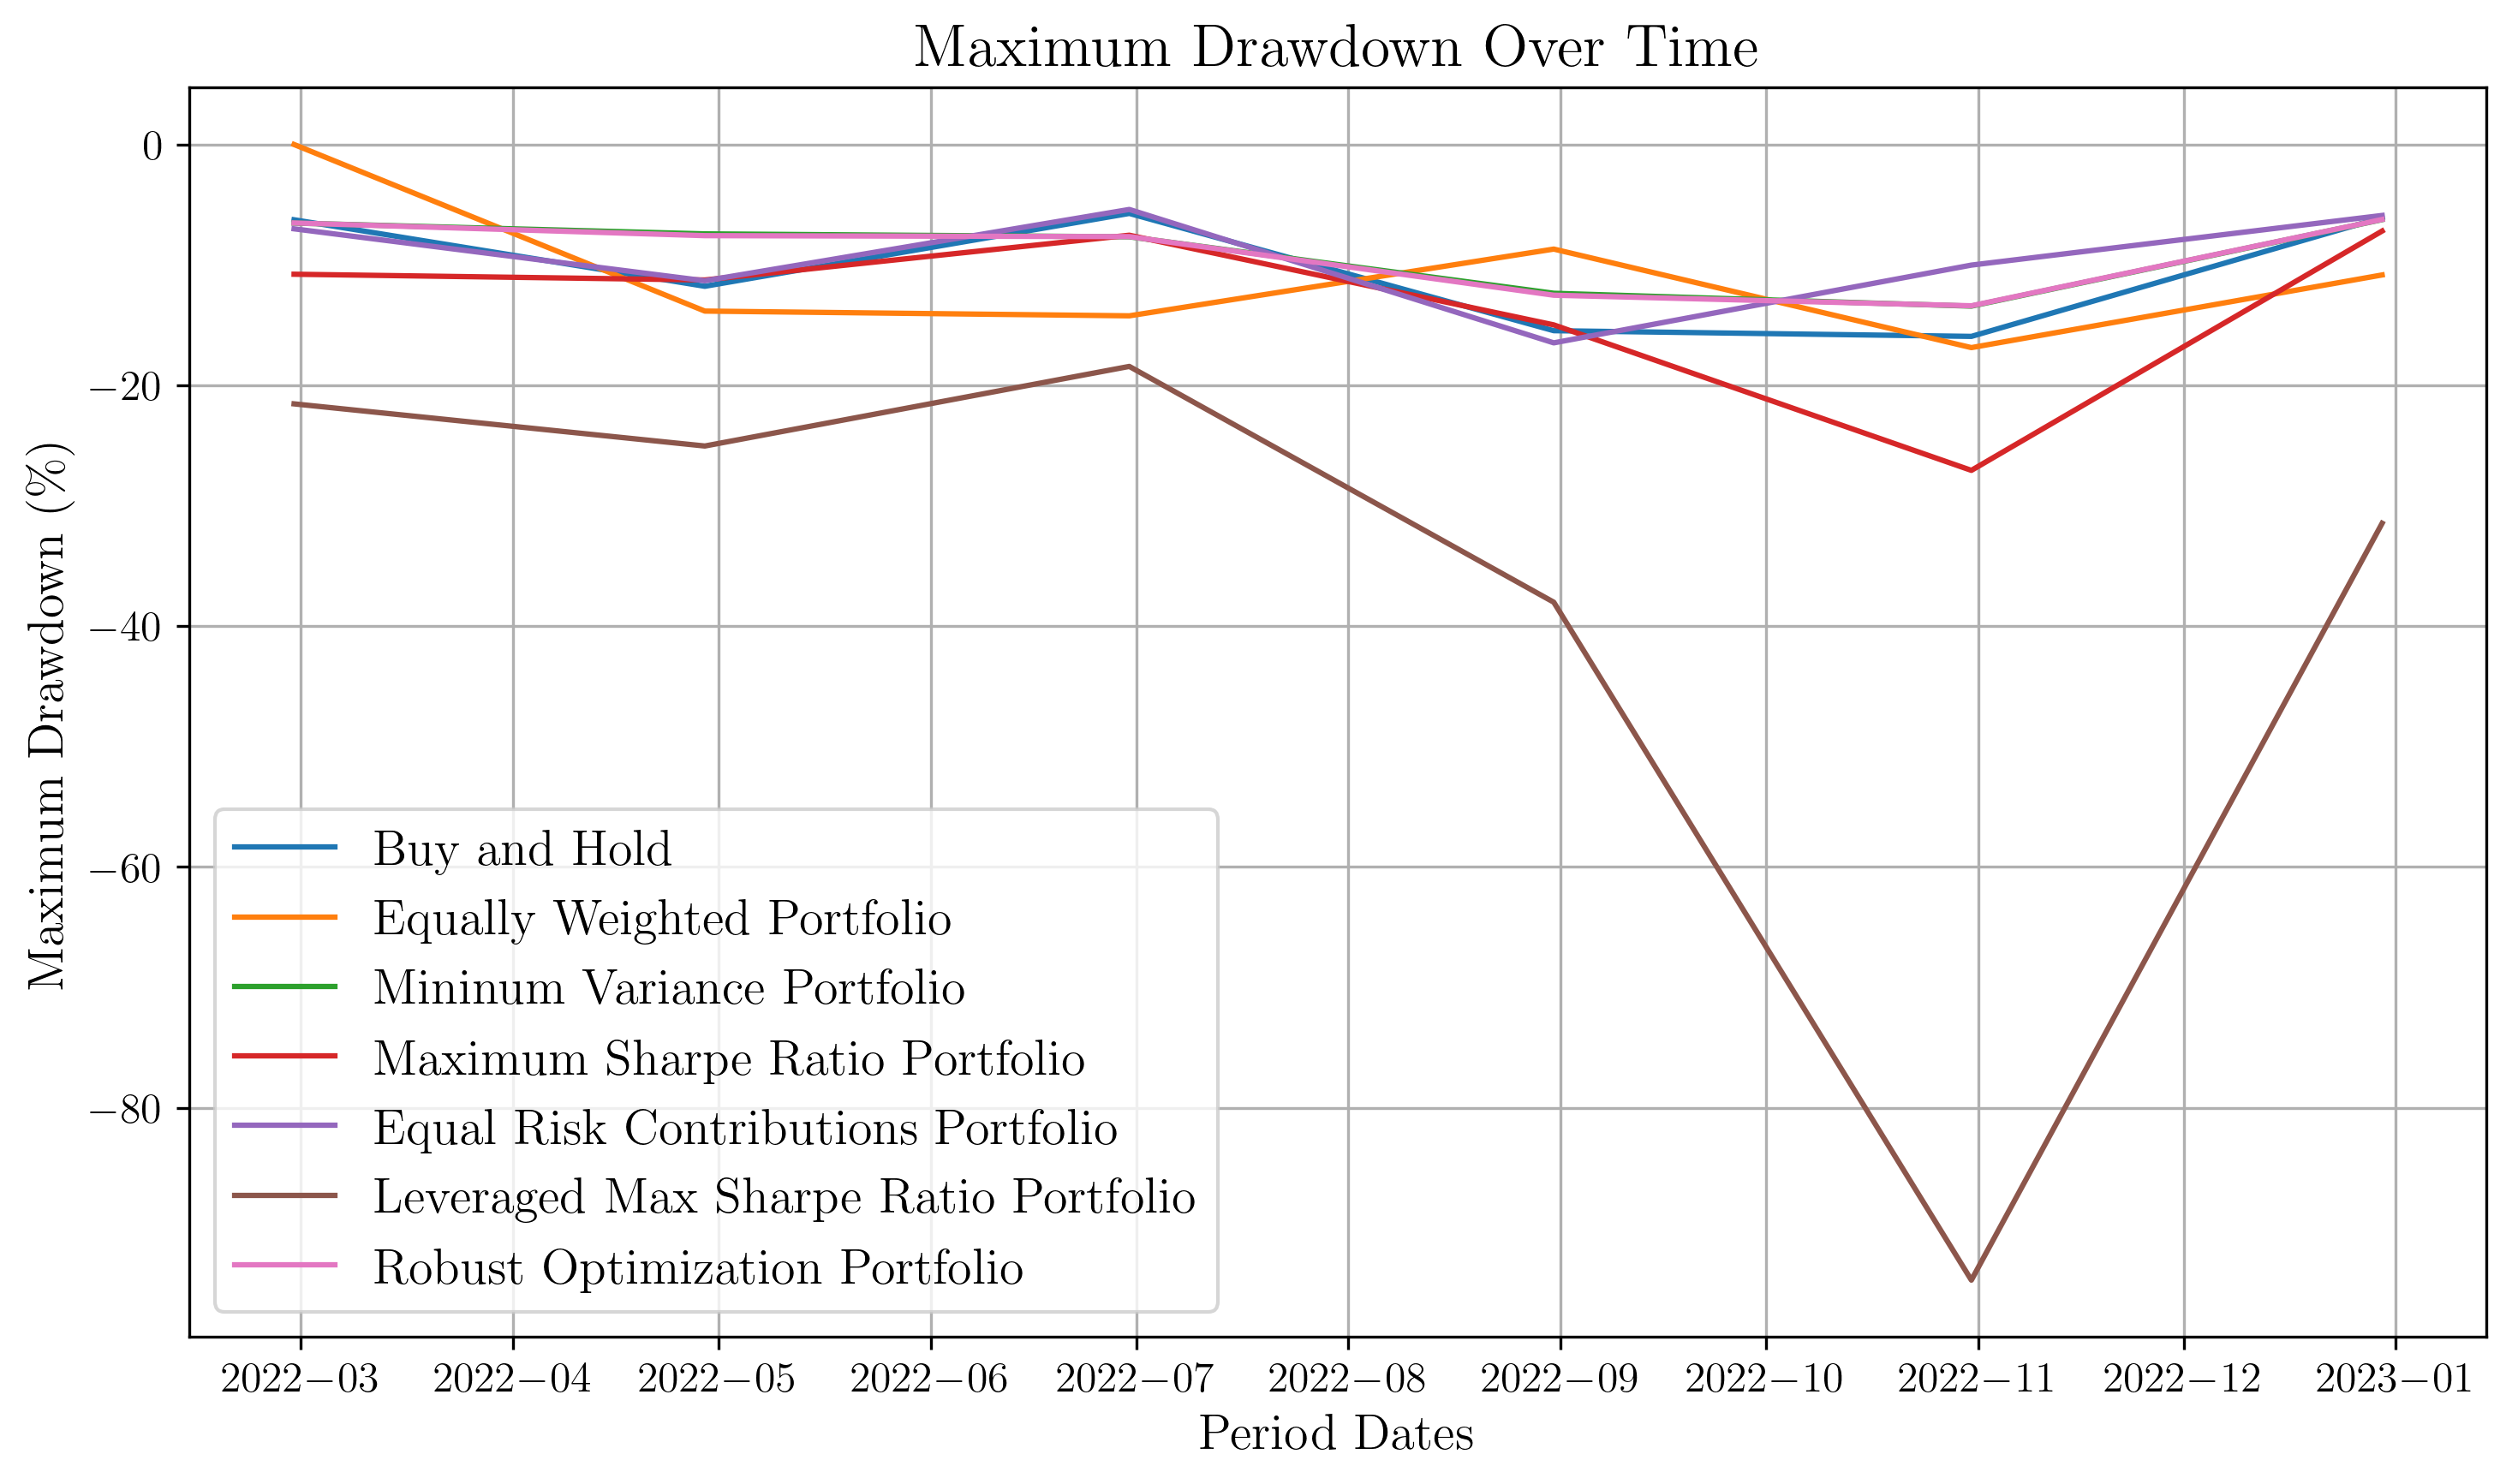

In [134]:
# Maximum Drawdown graph
# For porfolio value over time
period_dates = pd.to_datetime(period_dates) 

# Plotting
plt.figure(figsize=(10, 6), dpi=300)
for i in range(N_strat):
    plt.plot(period_dates, max_drawdowns[i, :], label=strategy_names[i])  # Convert drawdown to percentage
plt.xlabel('Period Dates')
plt.ylabel('Maximum Drawdown (\%)')
plt.title('Maximum Drawdown Over Time')

# Rotate date labels for better readability
# plt.setp(xaxis.get_majorticklabels(), rotation=45, ha="right")

plt.grid(True)
plt.legend()
plt.tight_layout()

# Specify the directory and filename where you want to save the figure
directory = '/Users/declanbracken/Development/UofT_Projects/MIE_1622/A2/Graphs/'
filename = 'DrawdownGraph_2022.png'
full_path = directory + filename
plt.savefig(full_path)

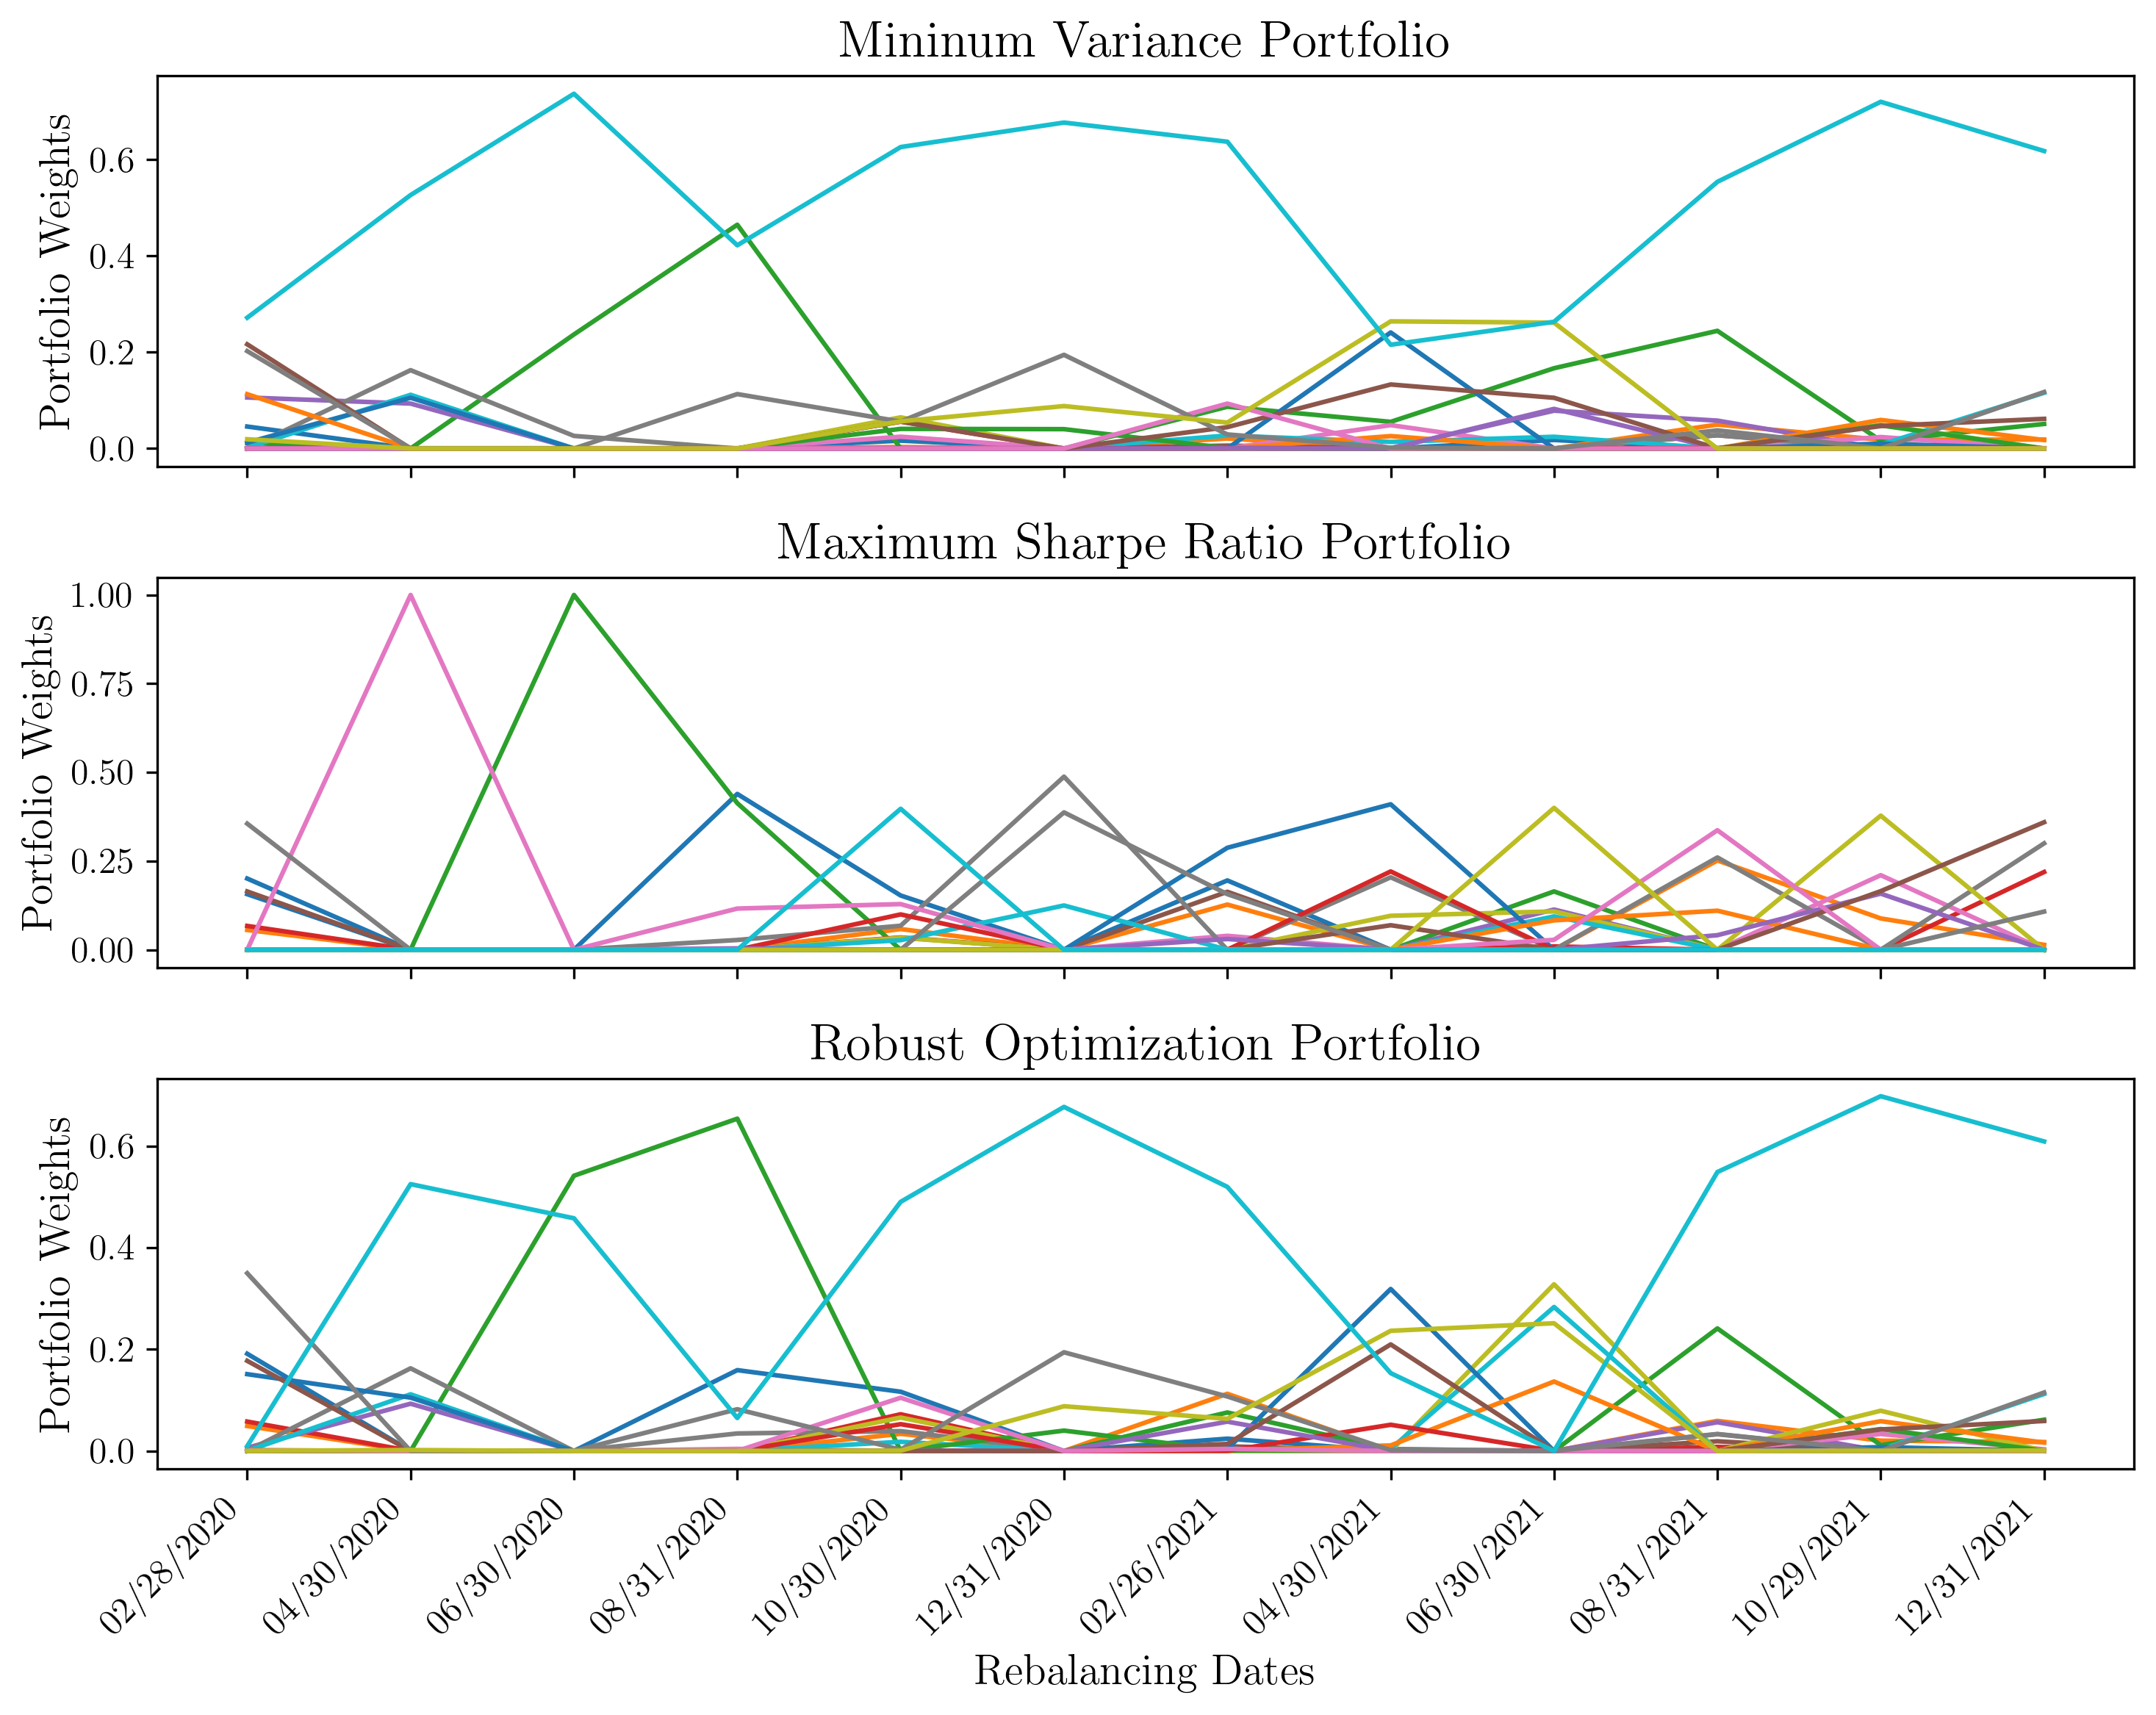

In [64]:
# Set the figure size and dpi
fig, axs = plt.subplots(3,1, sharex = True, sharey = False, figsize=(10, 8), dpi=300)
strategies_plotted = []

for i in range(N):
    axs[0].plot(period_dates, weights[2,:,i])
    axs[1].plot(period_dates, weights[3,:,i])
    axs[2].plot(period_dates, weights[6,:,i])

# Subsample x-axis ticks
# Setting legends
# axs[0].legend(fontsize=14)
# axs[1].legend(fontsize=14)
# axs[2].legend(fontsize=14)

for ax in axs:
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha="right")
    ax.set_ylabel("Portfolio Weights")
plt.xlabel("Rebalancing Dates")

axs[0].set_title(strategy_names[2])
axs[1].set_title(strategy_names[3])
axs[2].set_title(strategy_names[6])

plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha="right")
plt.tight_layout()

# Specify the directory and filename where you want to save the figure
directory = '/Users/declanbracken/Development/UofT_Projects/MIE_1622/A2/Graphs/'
filename = 'AllocationGraphs_2009.png'
full_path = directory + filename
# Save the figure
# plt.savefig(full_path)
plt.show()